## [모듈 2.3] 모델 배포 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 테스트 데이터 파일을 로딩
- 모델 배포 방식 결정
    - **처음 테스트시에는 로컬 배포(세이지메이커 노트북 인스턴스 사용)를 하시고, 완료되면 클라우드 배포를 하세요.**
    - 로컬 배포
    - 클라우드 배포
- 인퍼런스 코드 테스트 및 코드 설명
    - 추론시에 사용할 사용자 정의 코드를 로컬에서 테스트 합니다.
- 추가 패키지 설치    
- 세이지 메이커 모델 생성
- 모델을 엔드포인트에 배포
- 모델 추론 실행
- 엔드포인트 제거
    


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
%store -r test_file_path
%store -r s3_model_dir
%store -r local_model_dir

## 테스트 파일을 로딩
데이터를 로딩한 후에 test 데이터를 test_y, test_X로 분리 합니다. (훈련시에 사용한 데이터의 타입이 모두 float64 이기에, 똑같이 float64 로 타입을 변경 합니다.

In [3]:
df = pd.read_csv(test_file_path, header=None)
df = df.astype('float64')
test_y = df.iloc[:,0]
test_X = df.iloc[:,1:].to_numpy()
print("test_X : ", test_X.shape)

test_X :  (149, 59)


## 모델 배포 방식: 로컬 모드 파라미터
**아래 instance_type 에 따라서 로컬 모드, 클라우드 모드로 제어 합니다.
처음에는 로컬모드, 잘 동작하면 클라우드 모드로 바꾸어서 해보세요.**
- 로컬 모드이면 세이지 메이커의 로컬 세션이 할당이 됩니다.
    - 세이지 노트북 인스턴스에서 Docker Container가 생성이 되어서 배포를 합니다.
- 클라우드 모드이면 세이지 메이커에의 세션이 할당이 되어서, 클라우드에서 배포가 진행 됩니다.
    - 클라우드 상에서 EC2 인스턴스가 생성이 되고, 이 EC2안에서 Docker Container가 생성이 되어서 배포 합니다.

In [4]:
instance_type = 'local'
# instance_type="ml.c4.xlarge"

## 인퍼런스 코드 테스트

실제로 개발을 할시에 추론 코드의 로직 확인(디버깅 등)을 위해서 자주 추론 코드를 고치고 테스트 합니다. 그래서 이미 훈련된 모델을 로딩해서 추론 코드의 로직을 확인하는 과정을 합니다.

SK Learn Model의 배포 및 추론을 위해서 자세한 설명은 아래를 참조 하세요.
- [Deploy a Scikit-learn Model](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#deploy-a-scikit-learn-model)

## 인퍼런스 코드 설명 (src/inference.py)
아래는 실제 사용자가 정의한 model_fn, predict_fn를 inference.py 에 기술하였습니다. 
- 실제 아래의 추론시에 아래와 같은 로그를 확인하여 디버깅을 할 수 있습니다.

```
algo-1-l1rre_1  | From user-inference file- Model loaded: 
algo-1-l1rre_1  | From user-inference file- Shape of predictions:  (149,)
```
- 만약에 아래의 함수들을 기술하지 않으면 디폴트로 기술되어 있는 model_fn, predict_fn가 호출 됩니다.
- input_fn, output_fn 도 사용자 정의로 기술할 수 있습니다. 본 예제에서는 다루지 않았으나, 추후 사용자 정의가 필요하면 기술하여 inference.py 에 넣으시면 됩니다.

```python
import joblib, os

def model_fn(model_dir):
    """
    Deserialized and return fitted model
    Note that this should have the same name as the serialized model in the main method
    """   
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("From user-inference file- Model loaded: ")     
    
    return model

def predict_fn(input_data, model):
    """
    주어진 input_data를 
    """
    payload = input_data
    
    predictions = model.predict(payload)
    print("From user-inference file- Shape of predictions: ", predictions.shape)

    return predictions
```

In [5]:
import src.inference
from importlib import reload

# 사용자 정의 모듈 리로드 코드 입니다. 테스트 하면서 코드를 수정하면 아래와 같이 재로딩하면 반영이 됩니다.
src.inference = reload(src.inference) 

from src.inference import model_fn, predict_fn


def input_fn(input_data, request_content_type='text/csv'):
    """
    추론 형태에 맞게 입력 형태를 변경 합니다.
    """
    n_feature = input_data.shape[1]
    sample = input_data.reshape(-1,n_feature)
    return sample



In [6]:

# 추론 형태로 변환 합니다.
sample = input_fn(test_X[0:10])

# 모델 로딩
model = model_fn('model')
# 추론 실행
predictons = predict_fn(sample, model)
print(predictons)

From user-inference file- Model loaded: 
From user-inference file- Shape of predictions:  (10,)
[9009.52141965 8898.60110154 9070.22393936 8896.75830002 9007.29494076
 8956.76622499 9027.70385189 8892.29257649 8823.03814172 8790.10858581]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
import time
local_model_path = f'file://{os.getcwd()}/model/model.joblib'
endpoint_name = 'local-endpoint-scikit-learn-{}'.format(int(time.time()))

#### 참조: Docker 명령어
로컬로드로 실행시에는 로컬에서 다커가 실행이 됩니다. 하지만 다커가 종료가 되지 않은 상태이면, 터미널을 열고 아래 명령어를 사용하여 다커를 중지 시키고 다시 실행합니다.

- 현재 실행중인 컨테이너를 보여주기
``` 
docker container ls
```
- 현재 실행중인 컨테이너를 모두 정지 시키기
```
docker stop $(docker ps -a -q)
```


## 추가 패키지 설치
src/requirements.txt 안에 필요한 패키지를 기술 합니다. (예: ```pandas<2```). 이렇게 하면 엔드 포인트의 배포시에 설치가 됩니다.
requirements.txt 를 src 폴더안에 같은 위치에 있으면 세이지 메이커가 자동적으로 패키지를 설치 합니다.
```
algo-1-l1rre_1  | /miniconda3/bin/python -m pip install . -r requirements.txt
algo-1-l1rre_1  | Processing /opt/ml/code
algo-1-l1rre_1  | Requirement already satisfied: pandas<2 in /miniconda3/lib/python3.7/site-packages (from -r requirements.txt (line 1)) (1.1.3)
```

In [8]:
import sagemaker
from sagemaker import local

if instance_type == 'local':
    sess = local.LocalSession()
    model_path = local_model_path # 로컬에 저장된 모델 경로를 사용
else:
    sess = sagemaker.Session()
    model_path = s3_model_dir # S3 에 저장된 모델 경로를 사용

## 세이지 메이커 모델 생성

SKLearnModel 를 생성하여 sagemaker model을 생성합니다.
- model_data: 모델 아티팩트의 경로가 기술됨
- framework_version: 배포가 될 SKLearn Model의 버전이 정해짐
- entry_point: src/inference.py 인퍼런스 사용자 정의 코드가 기술됨
- sagemaker_session: 로컬 모드 혹은 클라우드 모드가 결정이 됨

In [9]:
from sagemaker import get_execution_role

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

FRAMEWORK_VERSION = "0.23-1"

from sagemaker.sklearn.model import SKLearnModel
sm_model = SKLearnModel(model_data = model_path,
                           role = role,
                           source_dir = 'src',
                           entry_point = 'inference.py',
                           framework_version = FRAMEWORK_VERSION,
                           py_version = 'py3',
                           sagemaker_session = sess                           
                          )


## 모델 배포 및 추론
세이지 메이커 모델을 바탕으로 배포를 합니다. 배포후에 predictor를 바탕으로 엔드포인트에 접근할 수 있습니다.
- instance_type: 로컬 모드인지 클라우드 인스턴스가 결정이 됩니다.

In [10]:
%%time

predictor = sm_model.deploy(
    initial_instance_count=1,
    instance_type= instance_type,
    endpoint_name = endpoint_name,
    wait=True
    )

Attaching to tmpw4r12ssk_algo-1-6o529_1
algo-1-6o529_1  | 2020-12-06 05:13:06,921 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-6o529_1  | 2020-12-06 05:13:06,925 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-6o529_1  | 2020-12-06 05:13:06,926 INFO - sagemaker-containers - nginx config: 
algo-1-6o529_1  | worker_processes auto;
algo-1-6o529_1  | daemon off;
algo-1-6o529_1  | pid /tmp/nginx.pid;
algo-1-6o529_1  | error_log  /dev/stderr;
algo-1-6o529_1  | 
algo-1-6o529_1  | worker_rlimit_nofile 4096;
algo-1-6o529_1  | 
algo-1-6o529_1  | events {
algo-1-6o529_1  |   worker_connections 2048;
algo-1-6o529_1  | }
algo-1-6o529_1  | 
algo-1-6o529_1  | http {
algo-1-6o529_1  |   include /etc/nginx/mime.types;
algo-1-6o529_1  |   default_type application/octet-stream;
algo-1-6o529_1  |   access_log /dev/stdout combined;
algo-1-6o529_1  | 
algo-1-6o529_1  |   upstream gunicorn {
algo-1-6o529_1  |     server unix:/tmp/guni

## 추론 실행

In [11]:
import p_utils
from importlib import reload
from p_utils import evaluate, show_chart

p_utils = reload(p_utils)

## 추론 입력 데이터 생성
sample = input_fn(test_X)
## 추론 실행
ridge_pred = predictor.predict(sample)

algo-1-6o529_1  | [2020-12-06 05:13:10 +0000] [2167] [INFO] Booting worker with pid: 2167
algo-1-6o529_1  | 2020-12-06 05:13:10,981 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2235] [INFO] Booting worker with pid: 2235
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2236] [INFO] Booting worker with pid: 2236
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2320] [INFO] Booting worker with pid: 2320
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2366] [INFO] Booting worker with pid: 2366
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2432] [INFO] Booting worker with pid: 2432
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2496] [INFO] Booting worker with pid: 2496
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2561] [INFO] Booting worker with pid: 2561
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2563] [INFO] Booting worker with pid: 2563
algo-1-6o529_1  | From user-inference file- Model loaded: 
algo-1-6o529

Ridge-onestep-ahead MdAPE =  0.017380620413302225
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2690] [INFO] Booting worker with pid: 2690
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2691] [INFO] Booting worker with pid: 2691
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2820] [INFO] Booting worker with pid: 2820
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2949] [INFO] Booting worker with pid: 2949
algo-1-6o529_1  | [2020-12-06 05:13:11 +0000] [2951] [INFO] Booting worker with pid: 2951


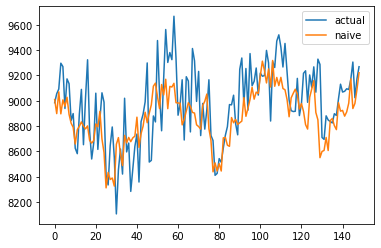

In [12]:

# Evaluate
MdAPE = evaluate(test_y, ridge_pred)
print('Ridge-onestep-ahead MdAPE = ', MdAPE)

# 차트로 보기
show_chart(test_y, ridge_pred) 

## Endpoint Cleanup
위에서 생성한 엔드포인트를 삭제 합니다. 

In [13]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
